### This code plots the 1D and 2D kinematics and differences in kinematics for lep1 and lep2 in $Z \rightarrow \ell\ell$ events. It has a few different switches:
1. `make_plain_kinem_plots` = A basic kinematic plotter to show the $\eta, p_{T}, \phi, \Delta \mathrm{R}$ for lep1 and lep2, side-by-side.

#### To Fix:
- If plotting $p_{T}$, make y-label have 'Events/[# GeV]'.

In [1]:
import sys
import os
sys.path.append('/Users/Jake/anaconda3/lib/python3.7/site-packages')

import swifter  # Adds efficient `apply()` functionality to DataFrames.
# ^Not actually sure if we need to use it...
import pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/Users/Jake/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')

# Neat tricks.
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Local imports. 
from PyUtils.fileUtils import makeDirs
from d0_Utils.d0_fns import add_underoverflow_entries

# pd.options.display.max_columns = 23
pd.options.display.max_columns = None

plt.style.use('cmsstyle_plot')

In [3]:
#--- Automatons ---#
def make_binning_array(lim_ls):
    """
    Turn a list of [bin_min, bin_max, bin_width] into an array of length = (bin_max - bin_min)/bin_width,
    whose first element is bin_min, last element is bin_max and has spacing bin_width.
    """
    ls_min = lim_ls[0]
    ls_max = lim_ls[1]
    ls_binw = lim_ls[2]
    
    return np.arange(ls_min, ls_max+0.5*ls_binw, ls_binw), ls_binw

def get_stats_1Dhist(data):
    """
    Return the statistics of array-like data.
    Particularly good for displaying the statistics on binned data in a histogram legend. 

    Parameters
    ----------
    data : array-like
        Your data (in the form of a list, numpy array, series, etc.) 

    Returns
    -------
    stats : list
        A 5-element list of the statistics of data.
        stats[0] -> n : int
            Number of entries in data.
        stats[1] -> mean : float
            Unweighted average of data. 
        stats[2] -> mean_err : float
            Standard error on the mean. 
        stats[3] -> stdev : float
            Standard deviation of data.
        stats[4] -> stdev : float 
            Standard error on the stdev. 
    """
    n = len(data)
    mean = np.mean(data)
    mean_err = abs(mean) / np.sqrt(n)
    stdev = np.std(data)
    stdev_err = stdev / np.sqrt(2*n)
    
    stats = [n, mean, mean_err, stdev, stdev_err]

    return stats

def make_stats_legend_for_1dhist(stats_ls):
    """
    Create a legend label that displays the statistics of a 1D histogram. 
    
    Parameters
    ----------
    stats_ls : list
        A 5-element list of statistics from the 1D data used to make the histogram. 
        
        stats_ls[0] -> number of entries in data
        stats_ls[1] -> mean of data
        stats_ls[2] -> standard error on the mean of data
        stats_ls[3] -> standard deviation of data
        stats_ls[4] -> standard error on the stdev of data
    
    Returns
    -------
    leg_label : str
        A string of the data statistics, useful for making a legend label. 
    """
    n = stats_ls[0]
    mean = stats_ls[1]
    mean_err = stats_ls[2]
    stdev = stats_ls[3]
    stdev_err = stats_ls[4]

    leg_label = (f"Total entries = {n:.2E}" + "\n"
                 f'Mean = {mean:.2E}' + r' $\pm$ ' + f'{mean_err:.2E}' + "\n"
                 f'Std Dev = {stdev:.2E}' + r' $\pm$ ' + f'{stdev_err:.2E}')

    return leg_label

def make_kinem_subplot(lep, ax, data, x_limits, x_bins, x_label, y_label, y_max=-1, log_scale=False):
    """
    Draw a kinematic distribution (e.g. eta1, gen_phi2, etc.) to a subplot in a figure.
    
    Parameters
    ----------
    lep : int
        Either `1` or `2`. Indicates which lepton you are referring to. 
    ax : axis object
        The axes to which plot will be drawn.
    data : array-like
        Data to be histogrammed. 
    x_limits : 2-element list
        A list of the x-min and x-max to be plotted.
    x_bins : array-like 
        Array of bin edges. Should be of length = len(data)+1.
    x_label : str
        Label for x-axis.
    y_label : str
        Label for y-axis.
    label_legend : str
        Label for legend.
    y_max : float
        Max on y-axis. If y_max <= 0, then matplotlib will choose y_max.
    log_scale : bool
        If True, sets the y-axis to log scale. 
    """
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    n_before = len(data)
    
    ax.set_xlim(x_limits)
    ax.grid(False)
    
    mod_data, n_underflow, n_overflow = add_underoverflow_entries(data, x_limits[0], x_limits[1])
    
    if y_max > 0: ax.set_ylim([0,y_max])
    if (log_scale): ax.set_yscale('log')
        
    stats = get_stats_1Dhist(data)
    label_legend = make_stats_legend_for_1dhist(stats)
    bin_vals, bin_edges, _ = ax.hist(mod_data, bins=x_bins, label=label_legend, histtype='step', color='b')
    ax.legend(loc='upper right', fontsize=7)
    
def delta_phi(phi2, phi1):
    """
    Calculate: phi2 - phi1 in the interval: [-pi, pi).
    Measure from lep1 to lep2. 
    Clockwise difference from 1 to 2 gives dphi < 0.
    Anticlockwise difference from 1 to 2 gives dphi > 0.
    
    Code converted from ROOT: https://root.cern.ch/doc/master/TVector2_8cxx_source.html#l00101
    
    Parameters
    ----------
    phi2 : float (or array-like)
        The azimuthal angle of, say, lepton 2. 
    phi1 : float (or array-like)
        The azimuthal angle of, say, lepton 1. 
        
    Returns
    -------
    dphi : float (or array-like)
        The difference in azimuthal angles in the range specified above.
    """
    # Using a Series. 
    if (isinstance(phi1, pandas.core.series.Series) or 
        isinstance(phi2, pandas.core.series.Series) 
       ):
        dphi = phi2 - phi1
        dphi = dphi.mask(dphi >= np.pi, dphi - 2*np.pi)
        dphi = dphi.mask(dphi < -np.pi, dphi + 2*np.pi)
        return dphi
    
    # Using floats.
    else:
        dphi = phi2 - phi1
        while (dphi >= np.pi): dphi -= 2*np.pi  
        while (dphi < np.pi): dphi += 2*np.pi
        return dphi

In [7]:
def root2feather(infile_root, outfile_fullpath):
    """
    Convert a .root file to DataFrame (DF) and store the DF as a binary .feather file.
    Use this function once and then you only have to load the .feather each time you want
    to analyze the data. 
    
    Parameters
    ----------
    infile_root : str
        The full path to the .root file. (/path/to/root/file)
    outfile_fullpath : str
        The full path to the outfile (.feather). (/path/to/feather/file)
        You should make sure it ends with '.feather'.
    """
    arr = root_numpy.root2array(infile_root)
    pd.DataFrame(arr).to_feather(outfile_fullpath)

In [6]:
myarr = np.random.rand(15,3)
df = pd.DataFrame(myarr, columns=['col1', 'col2', 'col1234'])
# pd.DataFrame.to_feather()
df.to_feather("/Users/Jake/Desktop/practice_feather.feather")

In [3]:
%%time
infile_path_MC_2016 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2016.feather'
infile_path_MC_2017 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2017.feather'
infile_path_MC_2018 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2018.feather'

df_MC_2016 = pd.read_feather(infile_path_MC_2016)
# df_MC_2017 = pd.read_feather(infile_path_MC_2017)
# df_MC_2018 = pd.read_feather(infile_path_MC_2018)

df_MC_2016 = df_MC_2016[df_MC_2016['GENmass2l'] > 0]
# df_MC_2017 = df_MC_2017[df_MC_2017['GENmass2l'] > 0]
# df_MC_2018 = df_MC_2018[df_MC_2018['GENmass2l'] > 0]

CPU times: user 1.66 s, sys: 3.37 s, total: 5.04 s
Wall time: 7.88 s


CPU times: user 18 s, sys: 5.18 s, total: 23.2 s
Wall time: 24.1 s


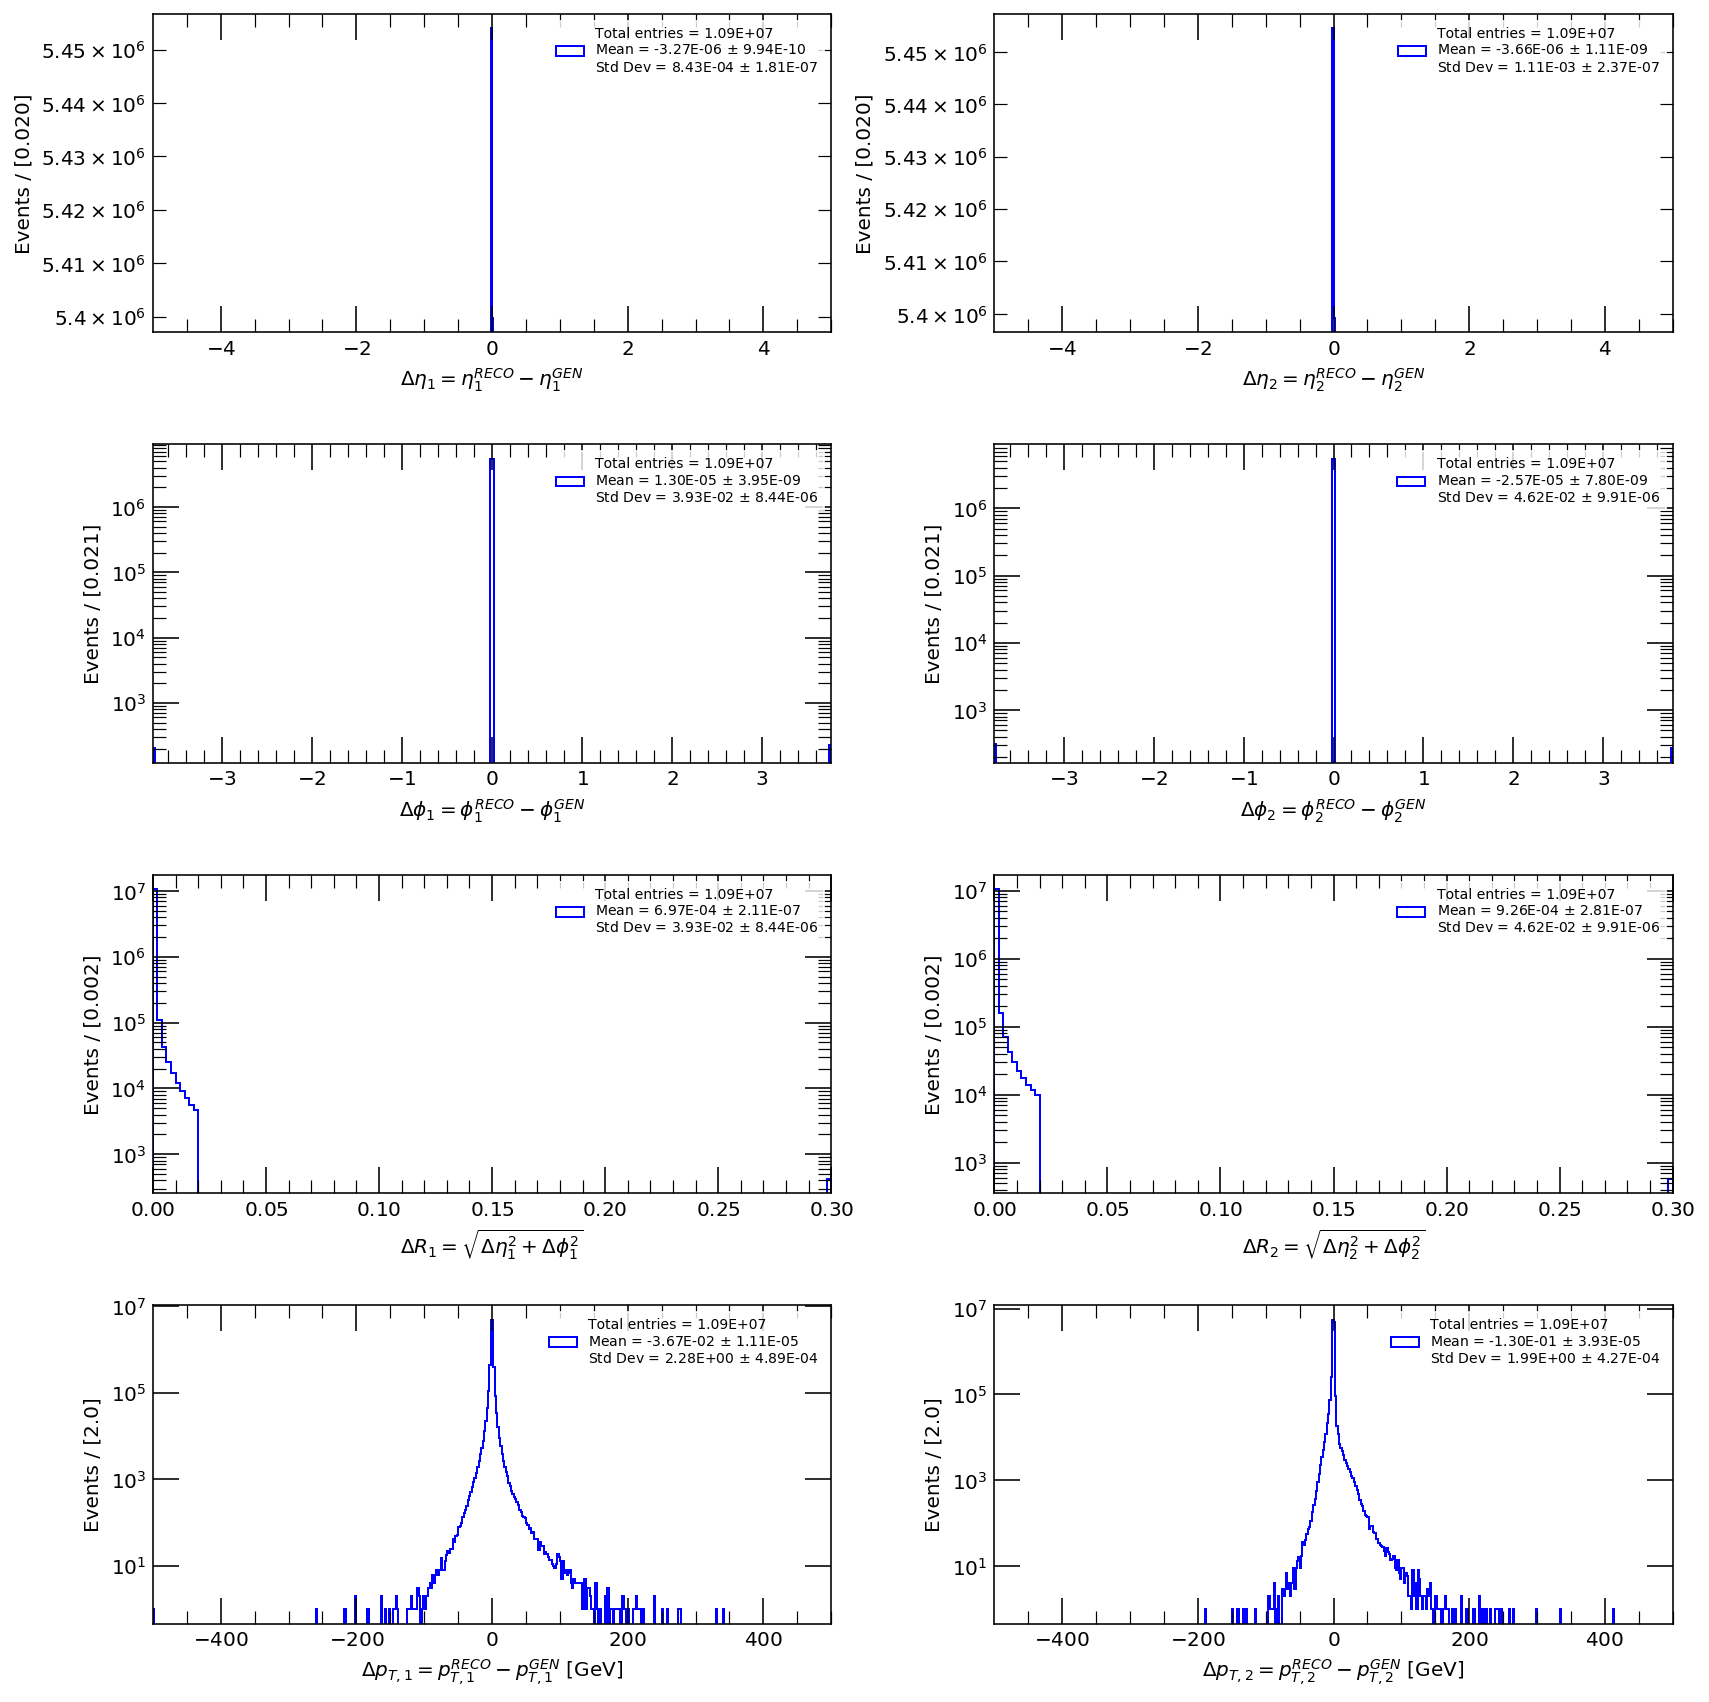

In [5]:
%%time
%config InlineBackend.figure_format ='retina'

#--- Quick Kinematics Difference Plotter ---#
#--- Plots the differences in kinematics between gen and reco levels. ---#
#--- May also do 2D plots ---#
log_scale = 1
save_file = 1
make_plain_kinem_plots = 0
make_delta_1D_plots = 1
make_2D_plots = 0
make_1overpT_plots = 0

apply_dR_LT_cut = (True, 0.02)  # dR < num
apply_dR_GT_cut = (False, 0.01)  # dR > num

y_max = -1  # If y_max <= 0, then let matplotlib figure out y_max.

outpath = '/Users/Jake/Desktop/test1/'
# file_name = 'MC_2016_dkinem_1D_plots__dR_lt_0p2_and_badGENmass2l_test4'
file_name = 'MC_2016_dkinem_1D_plots__dR_lt_0p2__goodGENmass2l'

# bin_min, bin_max, bin_width
eta_limits = [-2.5, 2.5, 0.025]
phi_limits = [-6/5*np.pi, 6/5*np.pi, 1/10*np.pi]
pT_limits = [0, 500, 1]

# delta_eta_limits = [-0.5, 0.5, 0.005]
delta_eta_limits = [-5, 5, 0.02]
# delta_phi_limits = [-np.pi/6, np.pi/6, np.pi/400]
delta_phi_limits = [-np.pi*6/5, np.pi*6/5, np.pi/150]
dR_limits = [0, 0.3, 0.002]
delta_pT_limits = [-500, 500, 2]

pT_2D_limits = [0, 100, 2]

#--- Automatons ---#
eta_bins, eta_bin_width = make_binning_array(eta_limits)
phi_bins, phi_bin_width = make_binning_array(phi_limits)
pT_bins, pT_bin_width = make_binning_array(pT_limits)

delta_eta_bins, delta_eta_bin_width = make_binning_array(delta_eta_limits)
delta_phi_bins, delta_phi_bin_width = make_binning_array(delta_phi_limits)
dR_bins, dR_bin_width = make_binning_array(dR_limits)
delta_pT_bins, delta_pT_bin_width = make_binning_array(delta_pT_limits)
pT_2D_bins, pT_2D_bin_width = make_binning_array(pT_2D_limits)

if (make_plain_kinem_plots + make_delta_1D_plots + make_2D_plots + make_1overpT_plots) > 1:
    raise RuntimeError("Make only 1 set of plots at a time. Stopping now.")
    
if (apply_dR_LT_cut[0] + apply_dR_GT_cut[0]) > 1:
    raise RuntimeError("Both dR cuts specified. Stopping now.")

#--- Analysis ---#
# Get kinematics series. 
eta1_gen_ser = df['genLep_eta1']
eta2_gen_ser = df['genLep_eta2']
phi1_gen_ser = df['genLep_phi1']
phi2_gen_ser = df['genLep_phi2']

eta1_rec_ser = df['eta1']
eta2_rec_ser = df['eta2']
phi1_rec_ser = df['phi1']
phi2_rec_ser = df['phi2']

deltaeta1_ser = eta1_rec_ser - eta1_gen_ser
deltaeta2_ser = eta2_rec_ser - eta2_gen_ser

# Remember that delta_phi requires special treatment:
# -pi < delta_phi < pi
deltaphi1_ser = delta_phi(phi1_rec_ser, phi1_gen_ser)
deltaphi2_ser = delta_phi(phi2_rec_ser, phi2_gen_ser)

dR1_ser = np.sqrt( deltaeta1_ser**2 + deltaphi1_ser**2 )
dR2_ser = np.sqrt( deltaeta2_ser**2 + deltaphi2_ser**2 )

# Possibly apply a dR cut. 
if (apply_dR_LT_cut[0]):
    # Reinitialize series with mask applied.
    df = df[(dR1_ser < apply_dR_LT_cut[1]) & (dR2_ser < apply_dR_LT_cut[1])]
    
    eta1_gen_ser = df['genLep_eta1']
    eta2_gen_ser = df['genLep_eta2']
    phi1_gen_ser = df['genLep_phi1']
    phi2_gen_ser = df['genLep_phi2']

    eta1_rec_ser = df['eta1']
    eta2_rec_ser = df['eta2']
    phi1_rec_ser = df['phi1']
    phi2_rec_ser = df['phi2']

    deltaeta1_ser = eta1_rec_ser - eta1_gen_ser
    deltaeta2_ser = eta2_rec_ser - eta2_gen_ser
    deltaphi1_ser = phi1_rec_ser - phi1_gen_ser
    deltaphi2_ser = phi2_rec_ser - phi2_gen_ser

    dR1_ser = np.sqrt( deltaeta1_ser**2 + deltaphi1_ser**2 )
    dR2_ser = np.sqrt( deltaeta2_ser**2 + deltaphi2_ser**2 )

elif (apply_dR_GT_cut[0]):
    # Reinitialize series with mask applied.
    df = df[(dR1_ser > apply_dR_GT_cut[1]) & (dR2_ser > apply_dR_GT_cut[1])]
    
    eta1_gen_ser = df['genLep_eta1']
    eta2_gen_ser = df['genLep_eta2']
    phi1_gen_ser = df['genLep_phi1']
    phi2_gen_ser = df['genLep_phi2']

    eta1_rec_ser = df['eta1']
    eta2_rec_ser = df['eta2']
    phi1_rec_ser = df['phi1']
    phi2_rec_ser = df['phi2']

    deltaeta1_ser = eta1_rec_ser - eta1_gen_ser
    deltaeta2_ser = eta2_rec_ser - eta2_gen_ser
    deltaphi1_ser = phi1_rec_ser - phi1_gen_ser
    deltaphi2_ser = phi2_rec_ser - phi2_gen_ser

    dR1_ser = np.sqrt( deltaeta1_ser**2 + deltaphi1_ser**2 )
    dR2_ser = np.sqrt( deltaeta2_ser**2 + deltaphi2_ser**2 )

pT1_gen_ser  = df['genLep_pt1']
pT2_gen_ser  = df['genLep_pt2']

pT1_rec_ser  = df['pT1']
pT2_rec_ser  = df['pT2']

deltapT1_ser = pT1_rec_ser - pT1_gen_ser
deltapT2_ser = pT2_rec_ser - pT2_gen_ser
            
#--- Plot eta, phi, pT for gen and reco, lep1, lep2 ---#
if (make_plain_kinem_plots):
    f = plt.figure(figsize=(12,12))
    count = 0
    # Make a 6x2 figure of plots: 
    #-- 6 rows = eta_gen, eta_reco, phi_gen, phi_reco, pT_gen, pT_reco
    #-- 2 cols = lep1, lep2
    for lep,ser in [(1,eta1_gen_ser), (2,eta2_gen_ser)]:
        ax = f.add_subplot(6,2,lep+count)
        ax.set_xlabel(r'$ \eta_{%d}^{GEN}$' % (lep))
        ax.set_ylabel(f'Events / [{eta_bin_width:.3f}]')
        
        # Stats.
        stats_ls = get_stats_1Dhist(ser)
        leg_label = make_stats_legend_for_1dhist(stats_ls)
        
        if y_max > 0: ax.set_ylim([0,y_max])
        if (log_scale): ax.set_yscale('log')
        deta_bin_vals, deta_bin_edges, _ = ax.hist(ser, bins=eta_bins, label=leg_label, histtype='step')
        ax.legend(loc='upper right')
    count += 2
    
    for lep,ser in [(1,eta1_rec_ser), (2, eta2_rec_ser)]:
        ax = f.add_subplot(6,2,lep+count)
        ax.set_xlabel(r'$ \eta_{%d}^{RECO}$' % (lep))
        ax.set_ylabel(f'Events / [{eta_bin_width:.3f}]')
        
        # Stats.
        n_entries = len(ser)
        mean = np.mean(ser)
        mean_err = abs(mean) / np.sqrt(n_entries)
        stdev = np.std(ser)
        stdev_err = stdev / np.sqrt(2*n_entries)
        label_legend = (f"Total entries = {n_entries:.2E}" + "\n"
                        f'Mean = {mean:.2E}' + r' $\pm$ ' + f'{mean_err:.2E}' + "\n"
                        f'Std Dev = {stdev:.2E}' + r' $\pm$ ' + f'{stdev_err:.2E}')
        if y_max > 0: ax_deta.set_ylim([0,y_max])
        if (log_scale): ax.set_yscale('log')
        deta_bin_vals, deta_bin_edges, _ = ax.hist(ser, bins=eta_bins, label=label_legend)
        ax.legend(loc='upper right')
    count += 2
        
    for lep,ser in [(1,phi1_gen_ser), (2, phi2_gen_ser)]:
        ax = f.add_subplot(6,2,lep+count)
        ax.set_xlabel(r'$ \phi_{%d}^{GEN}$' % (lep))
        ax.set_ylabel(f'Events / [{phi_bin_width:.3f}]')
        
        # Stats.
        n_entries = len(ser)
        mean = np.mean(ser)
        mean_err = abs(mean) / np.sqrt(n_entries)
        stdev = np.std(ser)
        stdev_err = stdev / np.sqrt(2*n_entries)
        label_legend = (f"Total entries = {n_entries:.2E}" + "\n"
                        f'Mean = {mean:.2E}' + r' $\pm$ ' + f'{mean_err:.2E}' + "\n"
                        f'Std Dev = {stdev:.2E}' + r' $\pm$ ' + f'{stdev_err:.2E}')
        if y_max > 0: ax_deta.set_ylim([0,y_max])
        if (log_scale): ax.set_yscale('log')
        deta_bin_vals, deta_bin_edges, _ = ax.hist(ser, bins=phi_bins, label=label_legend)
        ax.legend(loc='upper right')     
    count += 2
        
    for lep,ser in [(1,phi1_rec_ser), (2, phi2_rec_ser)]:
        ax = f.add_subplot(6,2,lep+count)
        ax.set_xlabel(r'$ \phi_{%d}^{RECO}$' % (lep))
        ax.set_ylabel(f'Events / [{phi_bin_width:.3f}]')
        
        # Stats.
        n_entries = len(ser)
        mean = np.mean(ser)
        mean_err = abs(mean) / np.sqrt(n_entries)
        stdev = np.std(ser)
        stdev_err = stdev / np.sqrt(2*n_entries)
        label_legend = (f"Total entries = {n_entries:.2E}" + "\n"
                        f'Mean = {mean:.2E}' + r' $\pm$ ' + f'{mean_err:.2E}' + "\n"
                        f'Std Dev = {stdev:.2E}' + r' $\pm$ ' + f'{stdev_err:.2E}')
        if y_max > 0: ax_deta.set_ylim([0,y_max])
        if (log_scale): ax.set_yscale('log')
        deta_bin_vals, deta_bin_edges, _ = ax.hist(ser, bins=phi_bins, label=label_legend)
        ax.legend(loc='upper right')     
    count += 2
        
        
        
#         fig = plt.figure()
#         ax = fig.add_axes([0.17,0.33,0.825,0.54])  # [low_left_corner_x, low_left_corner_y, width, height]
#         ax_ratio = fig.add_axes([0.17,0.12,0.825,0.20])

#         label_legend_gen = (f"GEN: {n_entries_gen} entries" + "\n"
#                             f'Mean = {mean_gen:.2E}' + r' $\pm$ ' + f'{mean_err_gen:.2E}',
#                             f'Std Dev = {stdev_gen:.2E}' + r' $\pm$ ' + f'{stdev_err_gen:.2E}')
#         label_legend_rec = (f"RECO: {n_entries_rec} entries" + "\n"
#                             f'Mean = {mean_rec:.2E}' + r' $\pm$ ' + f'{mean_err_rec:.2E}',
#                             f'Std Dev = {stdev_rec:.2E}' + r' $\pm$ ' + f'{stdev_err_rec:.2E}')
#         hist_bin_vals_gen, bin_edges_gen, _ = ax.hist(kinem_gen_ser, bins=x_val_arr, histtype='step', color='green', label=label_legend_gen)
#         hist_bin_vals_rec, bin_edges_rec, _ = ax.hist(kinem_rec_ser, bins=x_val_arr, histtype='step', color='red', label=label_legend_rec)

#         hist_bin_vals_gen_modified = hist_bin_vals_gen.copy()
#         hist_bin_vals_gen_modified[hist_bin_vals_gen == 0] = 0.0000001
#         ratio_vals = (hist_bin_vals_rec - hist_bin_vals_gen) / hist_bin_vals_gen_modified

#         ax_ratio.errorbar(x_val_arr[:-1]+0.5*x_bin_width, ratio_vals, xerr=x_bin_width/2, ecolor='black', ms=0, capsize=0, mew=0, drawstyle='steps-mid', alpha=1)

#         ax_ratio.grid(which='major',axis='x')
#         ax_ratio.grid(which='major',axis='y', ls='-')
#         ax_ratio.grid(which='minor',axis='y')

#         # Hide first tick label on y-axis, since it overlaps with ratio plot's tick label.
#         a=ax.get_yticks().tolist()
#         a[0]=''
#         ax.set_yticklabels(a)

#         # Hide main plot's x tick labels.
#         plt.setp(ax.get_xticklabels(), visible=False)

#         # Only show a few of the tick labels on ratio plot.
#         n_tick_labels = 5
#         ax_ratio.yaxis.set_major_locator(plt.MaxNLocator(n_tick_labels))
#         ax_ratio.axhline(c='r', lw=2, ls='-')

#         # Find x error bars, which may be asymmetrical.
#         ax.grid(which='major',color='k', ls=':')
#         ax.tick_params(axis='both', which='major', direction='in', length=9,   top=True, right=True)
#         ax.tick_params(axis='both', which='minor', direction='in', length=4.5, top=True, right=True)
#         plt.minorticks_on()
#         ax.set_ylabel(f"Events / [{x_bin_width:.1E}]", fontsize=textsize_axislabels)
#         ax.set_title(cuts, fontsize=textsize_title)

#         plt.minorticks_on()

#         ax.set_xlim([x_min, x_max])
#         ax_ratio.set_xlim([x_min, x_max])
#         ax_ratio.set_ylim([-0.12, 0.12])
#         ax_ratio.tick_params(axis='both', which='major', direction='in', length=6, top=True, right=True)
#         ax_ratio.tick_params(axis='both', which='minor', direction='in', length=3, top=True, right=True)
#         plt.minorticks_on()
#         x_axis_label = f'{kinem_gen}, {kinem_rec}'
#         if kinem_gen in kinem_pT_list:
#             x_axis_label += ' [GeV]'
#         ax_ratio.set_xlabel(x_axis_label)
#         ax_ratio.set_ylabel(r'$\frac{ (\mathrm{reco} - \mathrm{gen}) }{ \mathrm{gen} }$', fontsize=textsize_axislabels*1.5)

#         # Add a x10^ scale factor to the x-axis.
# #             formatter = ticker.ScalarFormatter(useMathText=True)
# #             formatter.set_powerlimits((-1,1))
# #             ax.xaxis.set_major_formatter(formatter)

#         y_max = max(max(hist_bin_vals_gen), max(hist_bin_vals_rec))
#         ax.set_ylim([0, y_max*1.4])

#         ax.legend(loc='upper right', framealpha=1, fontsize=textsize_legend)#, horizontalalignment='right')
        
        
        
#-----------------------------------------#
#--- Kinematic Difference (Reco - Gen) ---#
#-----------------------------------------#
if (make_delta_1D_plots):
    # Get kinematic differences: reco - gen
    
    #--- Plot it ---#
    fig = plt.figure(figsize=(12,12))

    #--- Plotting deta, dphi, dR, dpT ---#
    for lep,ser in [(1,deltaeta1_ser), (2, deltaeta2_ser)]:
        ax = fig.add_subplot(4,2,lep)
        x_label = r'$\Delta \eta_%d = \eta_{%d}^{RECO} - \eta_{%d}^{GEN}$' % (lep,lep,lep)
        y_label = f'Events / [{delta_eta_bin_width:.3f}]'
        make_kinem_subplot(lep, ax, ser, delta_eta_limits[:2], delta_eta_bins, x_label, y_label, y_max=y_max, log_scale=log_scale)
    
    for lep,ser in [(1,deltaphi1_ser), (2, deltaphi2_ser)]:
        ax = fig.add_subplot(4,2,lep+2)
        x_label = r'$\Delta \phi_%d = \phi_{%d}^{RECO} - \phi_{%d}^{GEN}$' % (lep,lep,lep)
        y_label = f'Events / [{delta_phi_bin_width:.3f}]'
        make_kinem_subplot(lep, ax, ser, delta_phi_limits[0:2], delta_phi_bins, x_label, y_label, y_max=y_max, log_scale=log_scale)

    for lep,ser in [(1,dR1_ser), (2,dR2_ser)]:
        ax = fig.add_subplot(4,2,lep+4)
        x_label = r'$\Delta R_{%d} = \sqrt{\Delta \eta_{%d}^{2} + \Delta \phi_{%d}^2}$' % (lep,lep,lep)
        y_label = f'Events / [{dR_bin_width:.3f}]'
        make_kinem_subplot(lep, ax, ser, dR_limits[0:2], dR_bins, x_label, y_label, y_max=y_max, log_scale=log_scale)

    for lep,ser in [(1,deltapT1_ser), (2,deltapT2_ser)]:
        ax = fig.add_subplot(4,2,lep+6)
        x_label = r'$\Delta p_{T,%d} = p_{T,{%d}}^{RECO} - p_{T,{%d}}^{GEN}$ [GeV]' % (lep,lep,lep)
        y_label = f'Events / [{delta_pT_bin_width:.1f}]'
        make_kinem_subplot(lep, ax, ser, delta_pT_limits[0:2], delta_pT_bins, x_label, y_label, y_max=y_max, log_scale=log_scale)

        
        
        
        
#--- 1/pT ---#
if (make_1overpT_plots):
    dpT1_overpTgen_ser = deltapT1_ser / pT1_gen_ser
    dpT2_overpTgen_ser = deltapT2_ser / pT2_gen_ser
    dpT1_overpTrec_ser = deltapT1_ser / pT1_rec_ser
    dpT2_overpTrec_ser = deltapT2_ser / pT2_rec_ser
    
    fig = plt.figure(figsize=(12,12))
    for lep,ser in [(1,dpT1_overpTgen_ser), (2,dpT2_overpTgen_ser)]:
        ax = fig.add_subplot(2,2,lep)
        ax.set_xlabel(r'$\Delta p_{T,%d}/p_{T}^{GEN} = (p_{T,{%d}}^{RECO} - p_{T,{%d}}^{GEN}) / p_{T,{%d}}^{GEN}$' % (lep,lep,lep,lep))
        ax.set_ylabel(f'Events / [{delta_pT_bin_width:.1f}]')
        if y_max > 0: ax.set_ylim([0,y_max])
        if (log_scale): ax.set_yscale('log')
        bin_vals, bin_edges, _ = ax.hist(ser, bins=delta_pT_bins)

    for lep,ser in [(1,dpT1_overpTrec_ser), (2,dpT2_overpTrec_ser)]:
        ax = fig.add_subplot(2,2,lep+2)
        ax.set_xlabel(r'$\Delta p_{T,%d}/p_{T}^{GEN} = (p_{T,{%d}}^{RECO} - p_{T,{%d}}^{GEN}) / p_{T,{%d}}^{RECO}$' % (lep,lep,lep,lep))
        ax.set_ylabel(f'Events / [{delta_pT_bin_width:.1f}]')
        if y_max > 0: ax.set_ylim([0,y_max])
        if (log_scale): ax.set_yscale('log')
        bin_vals, bin_edges, _ = ax.hist(ser, bins=delta_pT_bins)
        
#--- 2D Plots ---#
if (make_2D_plots):

    f = plt.figure(figsize=(12,12))
    for lep,x_ser,y_ser in [(1,pT1_gen_ser,pT1_rec_ser),
                            (2,pT2_gen_ser,pT2_rec_ser)]:
        ax = f.add_subplot(4,2,lep)
        ax.set_xlabel(r'$p_{T,%d}^{GEN}$ [GeV]' %lep)
        ax.set_ylabel(r'$p_{T,%d}^{RECO}$ [GeV]'%lep)
        if y_max > 0: ax.set_ylim([0,y_max])
        if (log_scale): ax.set_yscale('log')
        bin_vals, x_bin_edges, y_bin_edges, _ = ax.hist2d(x_ser, y_ser, bins=[pT_2D_bins, pT_2D_bins], cmap=plt.cm.Greys)
        plt.colorbar()

#--- Clean it up and save it. ---#
plt.tight_layout()
if (log_scale): 
    file_name += '_logy'
fullpath = os.path.join(outpath, file_name)
if (save_file):
    makeDirs(outpath)
    plt.savefig(fullpath + '.png')
    plt.savefig(fullpath + '.pdf')

# Testing.

In [ ]:
# n_tmp = len(df_MC_2016)
n_tmp = 150000
df_test = df_MC_2016[:n_tmp]
df_dphi = df_test['phi1'] - df_test['genLep_phi1']

In [ ]:
# Count how many are outside [-pi, pi)
print(len(df_dphi[df_dphi > np.pi]))
print(len(df_dphi[df_dphi < -np.pi]))

In [ ]:
hope_ser = delta_phi(df_test['phi1'], df_test['genLep_phi1'])

In [ ]:
len(hope_ser[(hope_ser >= -np.pi) & (hope_ser < np.pi)])

In [ ]:
test_df = pd.DataFrame({'reco':df_test['phi1'].values,
              'gen':df_test['genLep_phi1'].values,
               'reco-gen':df_dphi.values, 
               'mod':hope_ser.values})

In [ ]:
test_df[test_df['reco-gen'] > np.pi]

In [ ]:
print(len(hope_ser[(hope_ser >= -np.pi) & (hope_ser < np.pi)]))